In [1]:
# Import python libraries

from tensorflow.keras.models import load_model

import h5py   # HDF5 data file management library
import pandas as pd

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Add, BatchNormalization, Concatenate, AveragePooling2D, LeakyReLU, Lambda
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

inc = 0

import keras.backend as K


Using TensorFlow backend.


In [2]:
data_Mat = pd.read_csv('../input/colordata3/color_part_64tda.csv',header=None)
data_refl = pd.read_csv('../input/colordata3/color_spec_64tda.csv',header=None)
data_Mat2 = pd.read_csv('../input/colordata3b/color_part_64tda2.csv',header=None)
data_refl2 = pd.read_csv('../input/colordata3b/color_spec_64tda2.csv',header=None)
#data_refl = pd.read_csv('../input//rpoly64-n4/hsq_poly2p_reflag300cmda_n4_w_up.csv', header=None)

data_Mat = np.concatenate((data_Mat,data_Mat2),axis=0)#,data_Mat6,data_Mat7,data_Mat8,data_Mat9
data_refl = np.concatenate((data_refl,data_refl2),axis=0)#,data_psi6,data_psi7,data_psi8,data_psi9

#data_Mat = data_Mat.values;
#data_refl = data_refl.values;

s_mat = data_Mat.shape[1]

print(len(data_Mat)/s_mat)
print(len(data_refl))



31028.0
31028


In [3]:
#data_refl = data_refl.values;
#data_Mat = data_Mat.values;

data_Mat2 =  np.zeros([int(len(data_Mat)/s_mat), s_mat,s_mat]);
for ll in range(0,int(len(data_Mat)/s_mat)):
  data_Mat2[ll,0:s_mat,0:s_mat]= data_Mat[ll*s_mat:(ll+1)*s_mat,0:s_mat]
  
data_Mat2 = data_Mat2.reshape(data_Mat2.shape[0], s_mat, s_mat, 1) 


del data_Mat


In [4]:
r = [0.137,0.676,1.603,2.451,3.418,3.699,3.064,1.933,0.802,0.156,0.039,0.347,1.070,2.170,3.397,4.732,6.070,7.311,8.291,8.634,8.672,7.930,6.446,4.669,3.095,1.859,1.056,0.570,0.274,0.121,0.058]
g = [0.014,0.069,0.168,0.300,0.554,0.890,1.290,1.838,2.520,3.226,4.320,5.621,6.907,8.059,8.668,8.855,8.581,7.951,7.106,6.004,5.079,4.065,2.999,2.042,1.290,0.746,0.417,0.223,0.107,0.047,0.023]
b = [0.612,3.110,7.627,12.095,17.537,19.888,17.695,13.000,7.699,3.938,2.046,1.049,0.544,0.278,0.122,0.035,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
rgb = [r,g,b]

def r2xyz(data):
    l = data*rgb
    l = np.sum(l,axis=1)*0.01
    #l = l/np.sum(l)
    return l

In [5]:
r2xyz(data_refl[30005,:])

array([0.72657296, 0.80930745, 0.13723401])

In [6]:
data_color = np.zeros([len(data_refl),3])
for l in range(len(data_refl)):
    data_color[l,:] = r2xyz(data_refl[l,:])


[0.60237619 0.69990023 0.95112187]


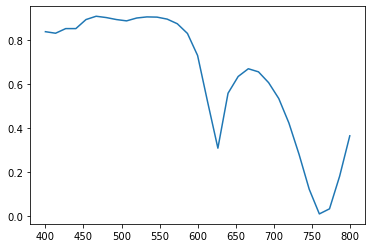

In [7]:
x = np.linspace(400,800,31)

plt.plot(x,data_refl[231,:])
#plt.plot(x,g/np.max(g),'g')
#plt.plot(x,r/np.max(r),'r')
#plt.plot(x,b/np.max(b),'b')

print(data_color[231])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


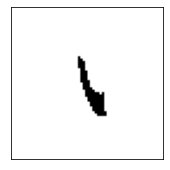

(0.0, 1.0)

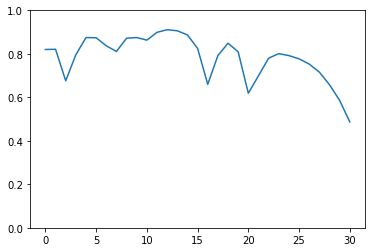

In [8]:
pos =11;
plt.subplot(1,2,2)
plt.imshow(data_Mat2[pos, :, :, 0], cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.show()
plt.plot(data_refl[pos,:])


axes = plt.gca()
axes.set_ylim([0,1])

In [9]:
#shuffling and dividing the data

indices = np.arange(data_Mat2.shape[0])
np.random.shuffle(indices)


data_Mat2 = data_Mat2[indices]
data_color =data_color[indices]

xtrain, xtest = np.split(
    data_Mat2, 
    [ int(.9*len(data_Mat2))
    ]
)

ytrain, ytest = np.split(
    data_color, 
    [int(.9*len(data_Mat2))
    ]
)


In [10]:
lr = 1e-4
optimizer_type = Adam()  # optimisation algorithm: SGD stochastic gradient decent 
loss = 'mean_squared_error'# "categorical_crossentropy" #  # loss (cost) function to be minimised by the optimiser
metrics = ['mean_squared_error']  # network accuracy metric to be determined after each epoch
dropout_ratio = 0.2  # % of nodes in the hidden layer to dropout during back-propagation update of the network weights
validtrain_split_ratio = 0.15  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 150  # maxmimum number of epochs to be iterated
batch_size = 16 # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
num_hidden = 25;  # number of nodes in hidden fully connected layer

In [11]:
def block(input_tensor,nb_filters,kernel_sh,stride_s):
  x = Conv2D(filters=nb_filters,kernel_size=kernel_sh,padding="same",strides = stride_s)(input_tensor)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  #x = Dropout(rate = 0.25)(x)
  return x

def resblock(input_tens,nb_filters,kernel_sh,stride_s):
    x = block(input_tens,nb_filters,kernel_sh,stride_s)
    x = block(x,nb_filters,kernel_sh,1)
    return x




In [12]:
input_shape = (data_Mat2.shape[1], data_Mat2.shape[1], 1);
inputs1 = Input(shape=input_shape)

conv1l = block(inputs1,32,16,1)
resblock1 = resblock(conv1l,32,16,1)

add1 = Add()([resblock1,conv1l])
resblock1b = resblock(add1,32,16,1)

add1b = Add()([resblock1b,add1])
resblock2 = resblock(add1b,32,16,2)

conv2l = Conv2D(filters=32,kernel_size=1,padding="same",strides = 2)(add1b)

add2 = Add()([resblock2,conv2l])
resblock2b = resblock(add2,32,16,1)

add2b = Add()([resblock2b,add2])
resblock3 = resblock(add2b,32,16,2)

conv3l = Conv2D(filters=32,kernel_size=1,padding="same",strides = 2)(add2b)

add3 = Add()([resblock3,conv3l])
resblock3b = resblock(add3,32,16,1)

add3b = Add()([resblock3b,add3])

flattenl = Flatten()(add3b)
dense_01l = Dense(num_hidden,kernel_regularizer = regularizers.l2(0.01))(flattenl)
dense_01l = LeakyReLU()(dense_01l)

#dense_02l = Dense(num_hidden,kernel_regularizer = regularizers.l2(0.01))(dense_01l)
#dense_02l = LeakyReLU()(dense_02l)

outputs1 = Dense(data_color.shape[1])(dense_01l)


* Compiling the network model *

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   8224        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________

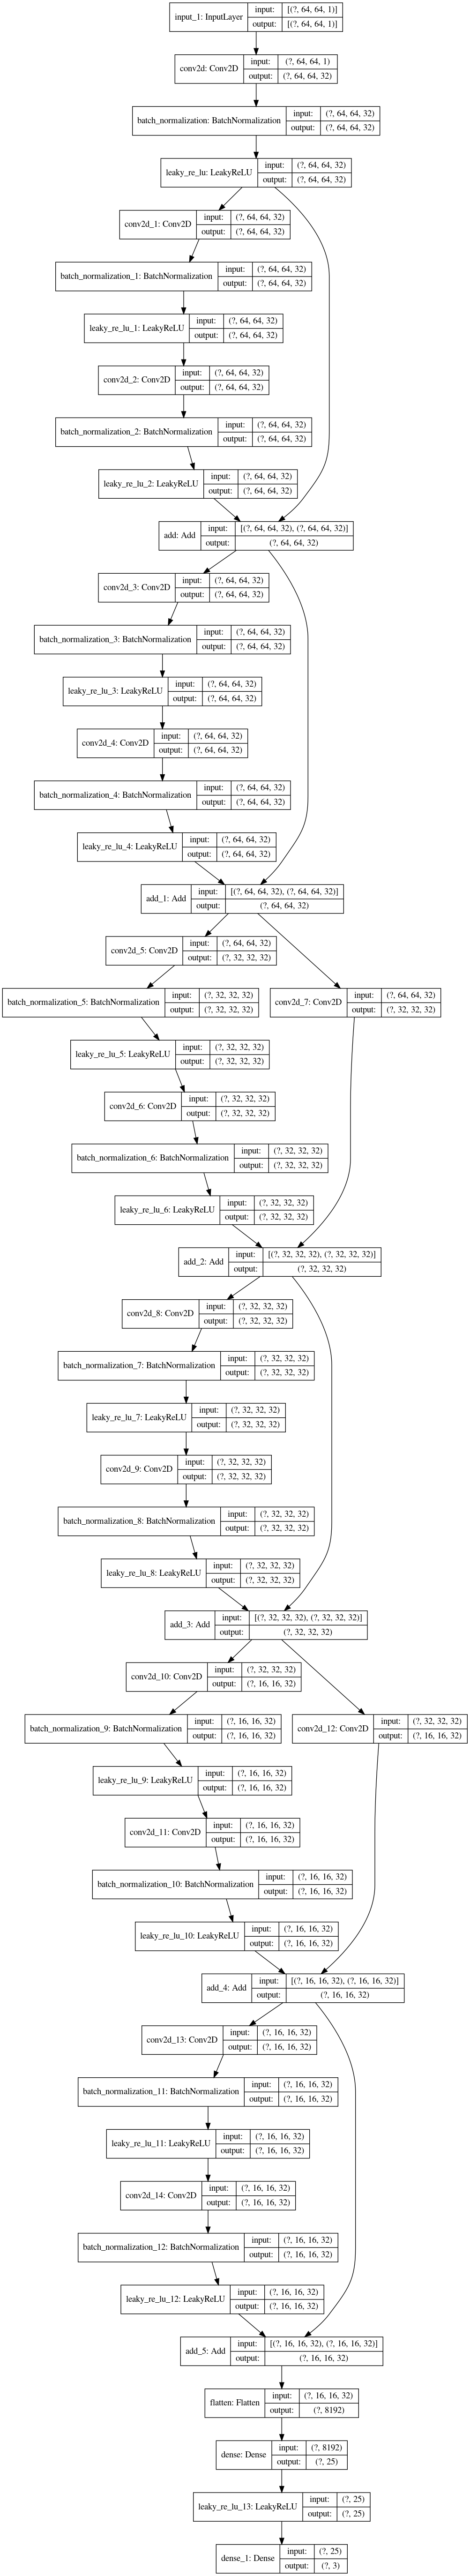

In [13]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs1, outputs=outputs1)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)
#model.load_weights('../input/model-forward/model_2p_lorentzhybrid_w_1001.h5')

# display a summary of the compiled neural network

print(model.summary())  
print()

# create and save a schematic image of the network architecture##

from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

In [14]:
inc = inc+1;
#es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

def schedule(epoch):
  return lr * (0.85 ** np.floor(epoch/5))
  
es = callbacks.LearningRateScheduler(schedule, verbose=1)
es2 = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=12, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#es3 = callbacks.ModelCheckpoint('model_2p_lorentz1024up.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(xtrain,ytrain, validation_split=0.2,
          batch_size=batch_size,
          epochs=max_epochs,
          verbose=1,
          callbacks=[es,es2])

history_t = history



Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/150
1397/1397 [==============================] - 51s 37ms/step - loss: 0.5726 - mean_squared_error: 0.1040 - val_loss: 0.4395 - val_mean_squared_error: 0.0126 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/150
1397/1397 [==============================] - 51s 36ms/step - loss: 0.3874 - mean_squared_error: 0.0159 - val_loss: 0.3279 - val_mean_squared_error: 0.0151 - lr: 1.0000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/150
1397/1397 [==============================] - 51s 36ms/step - loss: 0.2656 - mean_squared_error: 0.0120 - val_loss: 0.2088 - val_mean_squared_error: 0.0124 - lr: 1.0000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 4/150
1397/1397 [==============================] - 51s 37ms/step - loss: 0.1568 - mean_squared_error: 0.0094 - val_loss: 0.1111 - val_mean_squared_error: 0.0074 -

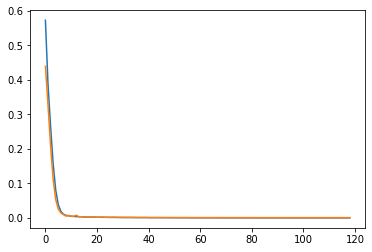

In [15]:
plt.plot(range(0,len(history.history['loss'])),history.history['loss'],range(0,len(history.history['loss'])),history.history['val_loss'])


In [16]:
#lam = pd.read_csv('drive/My Drive/Colab Notebooks/data_sets/lambda.csv', header=None)
#lam = np.squeeze(lam.values)

ans = model.predict([xtest])


(0.0, 1.0)

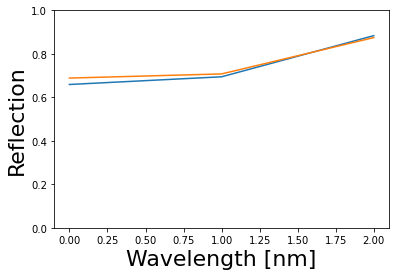

In [17]:
pos = 120;

plt.plot(ans[pos,:])
plt.plot(ytest[pos,:])

plt.xlabel('Wavelength [nm]',fontsize=22);plt.ylabel('Reflection',fontsize=22);

axes = plt.gca()
axes.set_ylim([0,1])

0.9775496084136441


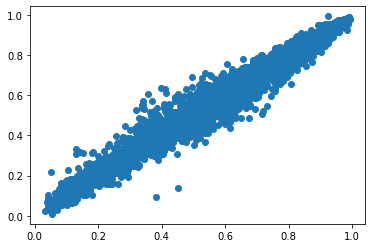

In [18]:
from scipy import stats

x=ytest
data_pred = model.predict(xtest)
y=data_pred

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x,y)
print(lm.score(x,y))
plt.scatter(x,y)

In [19]:
cylinders_model = model.save('Model_lorentz_n4_w1008.h5')
#best so far 0.0031

In [20]:
print('* Evaluating the performance of the trained network on the test dataset *')
print()

evaluate_model = model.evaluate(x=[xtest], y=ytest)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the test dataset *

97/97 [==============================] - 1s 15ms/step - loss: 0.0011 - mean_squared_error: 0.0010

Accuracy - mean_squared_error: 0.001
Loss - mean_squared_error: 0.001
